In [1]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


2024-04-13 12:06:43.179776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 12:06:43.179880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 12:06:43.340062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


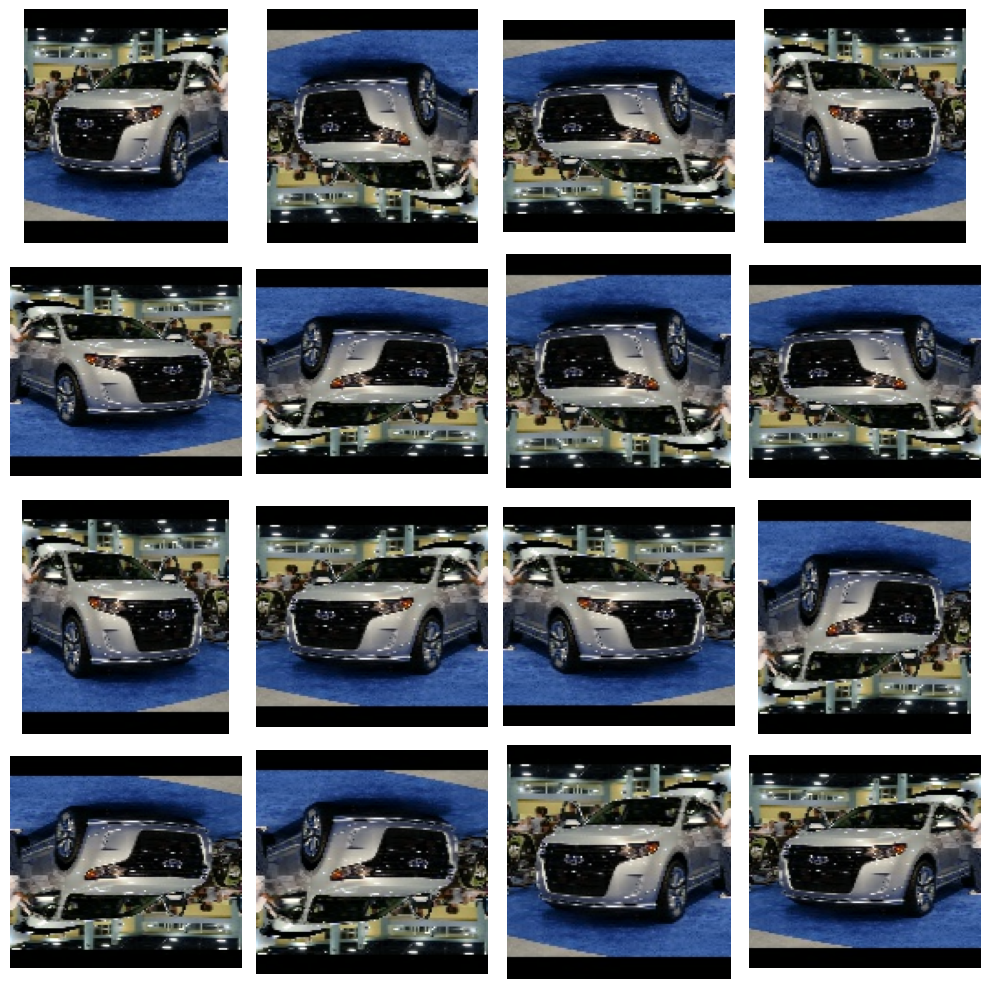

In [3]:

augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.15), # horizontal stretch
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Epoch 1/50


I0000 00:00:1713012618.004645     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 37s 330ms/step - loss: 0.6715 - binary_accuracy: 0.5783 - val_loss: 0.6488 - val_binary_accuracy: 0.5789
Epoch 2/50
80/80 [==============================] - 7s 86ms/step - loss: 0.6676 - binary_accuracy: 0.5656 - val_loss: 0.6804 - val_binary_accuracy: 0.5777
Epoch 3/50
80/80 [==============================] - 7s 86ms/step - loss: 0.6568 - binary_accuracy: 0.5787 - val_loss: 0.6316 - val_binary_accuracy: 0.5785
Epoch 4/50
80/80 [==============================] - 7s 87ms/step - loss: 0.6225 - binary_accuracy: 0.6428 - val_loss: 0.6105 - val_binary_accuracy: 0.6712
Epoch 5/50
80/80 [==============================] - 7s 87ms/step - loss: 0.6093 - binary_accuracy: 0.6826 - val_loss: 0.5974 - val_binary_accuracy: 0.6882
Epoch 6/50
80/80 [==============================] - 7s 87ms/step - loss: 0.5970 - binary_accuracy: 0.6990 - val_loss: 0.5992 - val_binary_accuracy: 0.6781
Epoch 7/50
80/80 [==============================] - 7s 86ms/step - loss: 0.5944

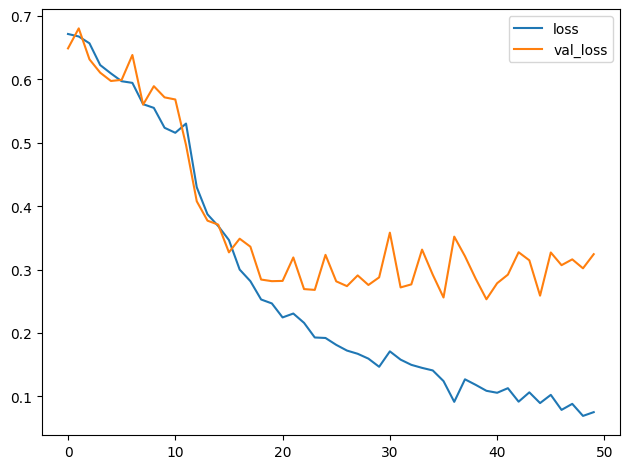

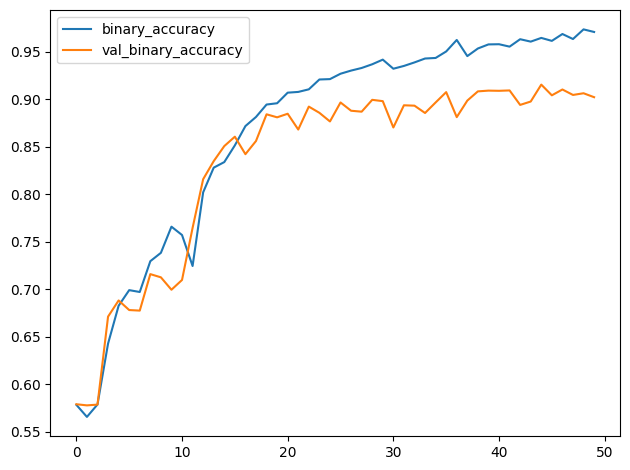

In [7]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();